# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.613539359882002 -2.8737301183786226
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [69]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [70]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [71]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [72]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [73]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [74]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs) # GAN using success rate
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:]) # Q-learning using max future rewards
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)# Policy gradient for state and action mapping
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [75]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [76]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [77]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [78]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [79]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [80]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR2.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:0.1506 dloss:0.7926 dlossR:0.7926 dlossQ:0.6856
Episode:1 meanR:9.5000 rate:0.0200 gloss:0.0697 dloss:0.7368 dlossR:0.7368 dlossQ:0.6911
Episode:2 meanR:9.6667 rate:0.0200 gloss:0.0057 dloss:0.6880 dlossR:0.6880 dlossQ:0.6932
Episode:3 meanR:9.2500 rate:0.0160 gloss:-0.0470 dloss:0.6475 dlossR:0.6475 dlossQ:0.6922
Episode:4 meanR:9.4000 rate:0.0200 gloss:-0.0936 dloss:0.6025 dlossR:0.6025 dlossQ:0.6880
Episode:5 meanR:9.3333 rate:0.0180 gloss:-0.1417 dloss:0.5696 dlossR:0.5696 dlossQ:0.6820
Episode:6 meanR:9.1429 rate:0.0160 gloss:-0.1697 dloss:0.5539 dlossR:0.5539 dlossQ:0.6781
Episode:7 meanR:9.2500 rate:0.0200 gloss:-0.2627 dloss:0.4941 dlossR:0.4941 dlossQ:0.6582
Episode:8 meanR:9.1111 rate:0.0160 gloss:-0.2933 dloss:0.4902 dlossR:0.4902 dlossQ:0.6570
Episode:9 meanR:9.2000 rate:0.0200 gloss:-0.3825 dloss:0.4457 dlossR:0.4457 dlossQ:0.6332
Episode:10 meanR:9.2727 rate:0.0200 gloss:0.1424 dloss:0.8040 dlossR:0.8040 dlossQ:0.6809
Episode:11 me

Episode:90 meanR:35.2747 rate:0.4640 gloss:-1.0913 dloss:1.0812 dlossR:1.0812 dlossQ:0.4702
Episode:91 meanR:35.6630 rate:0.1420 gloss:-1.3378 dloss:0.4143 dlossR:0.4143 dlossQ:0.3782
Episode:92 meanR:40.6559 rate:1.0000 gloss:-0.7764 dloss:2.2593 dlossR:2.2593 dlossQ:0.6365
Episode:93 meanR:41.9681 rate:0.3280 gloss:-1.2902 dloss:0.8330 dlossR:0.8330 dlossQ:0.4010
Episode:94 meanR:42.2947 rate:0.1460 gloss:-1.4087 dloss:0.4287 dlossR:0.4287 dlossQ:0.3600
Episode:95 meanR:42.7396 rate:0.1700 gloss:-1.4068 dloss:0.4857 dlossR:0.4857 dlossQ:0.3628
Episode:96 meanR:43.2784 rate:0.1900 gloss:-1.3317 dloss:0.5208 dlossR:0.5208 dlossQ:0.3848
Episode:97 meanR:43.4082 rate:0.1120 gloss:-1.4381 dloss:0.3566 dlossR:0.3566 dlossQ:0.3537
Episode:98 meanR:43.4343 rate:0.0920 gloss:-1.4226 dloss:0.3126 dlossR:0.3126 dlossQ:0.3588
Episode:99 meanR:43.4800 rate:0.0960 gloss:-1.3500 dloss:0.3193 dlossR:0.3193 dlossQ:0.3778
Episode:100 meanR:43.7800 rate:0.0780 gloss:-1.3691 dloss:0.2820 dlossR:0.2820 d

Episode:180 meanR:57.8600 rate:0.1120 gloss:-1.2429 dloss:0.3586 dlossR:0.3586 dlossQ:0.4154
Episode:181 meanR:58.2000 rate:0.0880 gloss:-1.2594 dloss:0.3105 dlossR:0.3105 dlossQ:0.4094
Episode:182 meanR:58.5100 rate:0.0840 gloss:-1.2927 dloss:0.3039 dlossR:0.3039 dlossQ:0.4005
Episode:183 meanR:59.3200 rate:0.1880 gloss:-1.1507 dloss:0.4981 dlossR:0.4981 dlossQ:0.4428
Episode:184 meanR:59.8200 rate:0.1300 gloss:-1.2205 dloss:0.3889 dlossR:0.3889 dlossQ:0.4187
Episode:185 meanR:60.6300 rate:0.1980 gloss:-1.1447 dloss:0.5166 dlossR:0.5166 dlossQ:0.4449
Episode:186 meanR:61.3300 rate:0.1780 gloss:-1.1801 dloss:0.4820 dlossR:0.4820 dlossQ:0.4337
Episode:187 meanR:62.0200 rate:0.2000 gloss:-1.1497 dloss:0.5217 dlossR:0.5217 dlossQ:0.4430
Episode:188 meanR:62.4300 rate:0.1580 gloss:-1.1820 dloss:0.4453 dlossR:0.4453 dlossQ:0.4358
Episode:189 meanR:62.8500 rate:0.1660 gloss:-1.1720 dloss:0.4597 dlossR:0.4597 dlossQ:0.4380
Episode:190 meanR:61.1800 rate:0.1300 gloss:-1.2812 dloss:0.3957 dloss

Episode:271 meanR:328.9700 rate:0.2320 gloss:0.6080 dloss:0.9445 dlossR:0.9445 dlossQ:0.5990
Episode:272 meanR:329.8200 rate:0.2420 gloss:0.5628 dloss:0.9119 dlossR:0.9119 dlossQ:0.6069
Episode:273 meanR:331.0800 rate:0.3100 gloss:0.1957 dloss:0.7426 dlossR:0.7426 dlossQ:0.6475
Episode:274 meanR:332.3100 rate:0.3200 gloss:0.1347 dloss:0.7404 dlossR:0.7404 dlossQ:0.6386
Episode:275 meanR:333.1500 rate:0.2600 gloss:0.0701 dloss:0.7498 dlossR:0.7498 dlossQ:0.6159
Episode:276 meanR:334.0800 rate:0.2520 gloss:-0.0016 dloss:0.7308 dlossR:0.7308 dlossQ:0.6152
Episode:277 meanR:334.3100 rate:0.1420 gloss:0.2031 dloss:0.7827 dlossR:0.7827 dlossQ:0.6612
Episode:278 meanR:334.4900 rate:0.1300 gloss:0.3050 dloss:0.8444 dlossR:0.8444 dlossQ:0.6588
Episode:279 meanR:334.7300 rate:0.1240 gloss:0.2680 dloss:0.8235 dlossR:0.8235 dlossQ:0.6646
Episode:280 meanR:334.6700 rate:0.1000 gloss:0.3071 dloss:0.8655 dlossR:0.8655 dlossQ:0.6626
Episode:281 meanR:335.0800 rate:0.1700 gloss:0.4689 dloss:0.9111 dlos

Episode:371 meanR:47.8300 rate:0.0180 gloss:-1.1852 dloss:0.1815 dlossR:0.1815 dlossQ:0.4186
Episode:372 meanR:46.7300 rate:0.0220 gloss:-1.2297 dloss:0.1828 dlossR:0.1828 dlossQ:0.4047
Episode:373 meanR:45.3000 rate:0.0240 gloss:-1.4203 dloss:0.1613 dlossR:0.1613 dlossQ:0.3464
Episode:374 meanR:43.8200 rate:0.0240 gloss:-1.5277 dloss:0.1504 dlossR:0.1504 dlossQ:0.3163
Episode:375 meanR:42.6100 rate:0.0180 gloss:-1.3566 dloss:0.1551 dlossR:0.1551 dlossQ:0.3650
Episode:376 meanR:41.4700 rate:0.0240 gloss:-1.5539 dloss:0.1481 dlossR:0.1481 dlossQ:0.3103
Episode:377 meanR:40.9200 rate:0.0320 gloss:-1.7340 dloss:0.1562 dlossR:0.1562 dlossQ:0.2665
Episode:378 meanR:40.4400 rate:0.0340 gloss:-1.6616 dloss:0.1661 dlossR:0.1661 dlossQ:0.2860
Episode:379 meanR:40.0700 rate:0.0500 gloss:-1.6582 dloss:0.2078 dlossR:0.2078 dlossQ:0.2893
Episode:380 meanR:39.8700 rate:0.0600 gloss:-1.6365 dloss:0.2363 dlossR:0.2363 dlossQ:0.2976
Episode:381 meanR:39.4800 rate:0.0920 gloss:-1.6337 dloss:0.3172 dloss

Episode:463 meanR:54.0000 rate:0.0260 gloss:-1.6147 dloss:0.1536 dlossR:0.1536 dlossQ:0.3013
Episode:464 meanR:53.9700 rate:0.0320 gloss:-1.5828 dloss:0.1702 dlossR:0.1702 dlossQ:0.3108
Episode:465 meanR:54.0200 rate:0.0440 gloss:-1.5986 dloss:0.1960 dlossR:0.1960 dlossQ:0.3068
Episode:466 meanR:58.5500 rate:0.9440 gloss:-1.1370 dloss:2.5473 dlossR:2.5473 dlossQ:0.5024
Episode:467 meanR:59.0800 rate:0.1440 gloss:-1.7930 dloss:0.4674 dlossR:0.4674 dlossQ:0.2662
Episode:468 meanR:59.2400 rate:0.0640 gloss:-1.6909 dloss:0.2435 dlossR:0.2435 dlossQ:0.2845
Episode:469 meanR:59.3200 rate:0.0420 gloss:-1.5480 dloss:0.1957 dlossR:0.1957 dlossQ:0.3197
Episode:470 meanR:59.3500 rate:0.0260 gloss:-1.5599 dloss:0.1584 dlossR:0.1584 dlossQ:0.3149
Episode:471 meanR:59.3700 rate:0.0220 gloss:-1.5457 dloss:0.1509 dlossR:0.1509 dlossQ:0.3179
Episode:472 meanR:59.3600 rate:0.0200 gloss:-1.5026 dloss:0.1523 dlossR:0.1523 dlossQ:0.3307
Episode:473 meanR:59.3500 rate:0.0220 gloss:-1.5952 dloss:0.1468 dloss

Episode:552 meanR:100.2300 rate:1.0000 gloss:-0.3150 dloss:1.6773 dlossR:1.6773 dlossQ:0.7781
Episode:553 meanR:105.0400 rate:1.0000 gloss:-0.2622 dloss:1.6172 dlossR:1.6172 dlossQ:0.7857
Episode:554 meanR:109.5500 rate:1.0000 gloss:-0.2059 dloss:1.5509 dlossR:1.5509 dlossQ:0.7963
Episode:555 meanR:113.9500 rate:1.0000 gloss:-0.1594 dloss:1.4967 dlossR:1.4967 dlossQ:0.8039
Episode:556 meanR:113.9500 rate:1.0000 gloss:-0.1075 dloss:1.4381 dlossR:1.4381 dlossQ:0.8097
Episode:557 meanR:118.8500 rate:1.0000 gloss:-0.0670 dloss:1.3935 dlossR:1.3935 dlossQ:0.8127
Episode:558 meanR:123.2200 rate:1.0000 gloss:-0.0195 dloss:1.3416 dlossR:1.3416 dlossQ:0.8153
Episode:559 meanR:127.5900 rate:1.0000 gloss:0.0274 dloss:1.2918 dlossR:1.2918 dlossQ:0.8161
Episode:560 meanR:132.1900 rate:1.0000 gloss:0.0651 dloss:1.2522 dlossR:1.2522 dlossQ:0.8159
Episode:561 meanR:137.0200 rate:1.0000 gloss:0.1126 dloss:1.2030 dlossR:1.2030 dlossQ:0.8144
Episode:562 meanR:141.8600 rate:1.0000 gloss:0.1533 dloss:1.161

Episode:643 meanR:347.9100 rate:0.3040 gloss:-0.1321 dloss:0.6764 dlossR:0.6764 dlossQ:0.6505
Episode:644 meanR:349.3000 rate:0.3520 gloss:-0.2043 dloss:0.6879 dlossR:0.6879 dlossQ:0.6583
Episode:645 meanR:350.5100 rate:0.3380 gloss:-0.0603 dloss:0.6636 dlossR:0.6636 dlossQ:0.6899
Episode:646 meanR:351.2900 rate:0.3100 gloss:-0.2132 dloss:0.6594 dlossR:0.6594 dlossQ:0.6571
Episode:647 meanR:350.7400 rate:0.2580 gloss:-0.1849 dloss:0.6357 dlossR:0.6357 dlossQ:0.6576
Episode:648 meanR:348.8900 rate:0.2060 gloss:-0.1012 dloss:0.6405 dlossR:0.6405 dlossQ:0.6615
Episode:649 meanR:345.5800 rate:0.2100 gloss:-0.0417 dloss:0.6505 dlossR:0.6505 dlossQ:0.6724
Episode:650 meanR:341.2500 rate:0.1340 gloss:-0.1064 dloss:0.6185 dlossR:0.6185 dlossQ:0.6734
Episode:651 meanR:337.0100 rate:0.1520 gloss:0.0355 dloss:0.6740 dlossR:0.6740 dlossQ:0.6824
Episode:652 meanR:332.5700 rate:0.1120 gloss:0.0193 dloss:0.6725 dlossR:0.6725 dlossQ:0.6852
Episode:653 meanR:328.0800 rate:0.1020 gloss:-0.0008 dloss:0.6

Episode:735 meanR:70.3600 rate:0.0580 gloss:-0.3444 dloss:0.4841 dlossR:0.4841 dlossQ:0.6605
Episode:736 meanR:69.6700 rate:0.0540 gloss:-0.3828 dloss:0.4658 dlossR:0.4658 dlossQ:0.6540
Episode:737 meanR:69.0800 rate:0.0660 gloss:-0.4531 dloss:0.4450 dlossR:0.4450 dlossQ:0.6385
Episode:738 meanR:68.4400 rate:0.0580 gloss:-0.4549 dloss:0.4396 dlossR:0.4396 dlossQ:0.6387
Episode:739 meanR:67.7600 rate:0.0400 gloss:-0.4789 dloss:0.4197 dlossR:0.4197 dlossQ:0.6348
Episode:740 meanR:66.9500 rate:0.0380 gloss:-0.5937 dloss:0.3732 dlossR:0.3732 dlossQ:0.6081
Episode:741 meanR:66.0200 rate:0.0280 gloss:-0.6142 dloss:0.3583 dlossR:0.3583 dlossQ:0.6033
Episode:742 meanR:65.0700 rate:0.0320 gloss:-0.6577 dloss:0.3465 dlossR:0.3465 dlossQ:0.5919
Episode:743 meanR:63.7700 rate:0.0440 gloss:-0.6663 dloss:0.3562 dlossR:0.3562 dlossQ:0.5875
Episode:744 meanR:62.2300 rate:0.0440 gloss:-0.7219 dloss:0.3399 dlossR:0.3399 dlossQ:0.5718
Episode:745 meanR:60.6400 rate:0.0200 gloss:-0.8108 dloss:0.2910 dloss

Episode:827 meanR:123.8900 rate:0.1020 gloss:-0.5571 dloss:0.4431 dlossR:0.4431 dlossQ:0.6146
Episode:828 meanR:124.1900 rate:0.1660 gloss:-0.4800 dloss:0.5062 dlossR:0.5062 dlossQ:0.6340
Episode:829 meanR:124.6700 rate:0.1780 gloss:-0.4364 dloss:0.5221 dlossR:0.5221 dlossQ:0.6443
Episode:830 meanR:125.8400 rate:0.3120 gloss:-0.3131 dloss:0.6274 dlossR:0.6274 dlossQ:0.6763
Episode:831 meanR:127.4200 rate:0.4080 gloss:-0.2412 dloss:0.7002 dlossR:0.7002 dlossQ:0.6948
Episode:832 meanR:132.1200 rate:1.0000 gloss:0.2244 dloss:1.0924 dlossR:1.0924 dlossQ:0.8058
Episode:833 meanR:136.8200 rate:1.0000 gloss:0.2562 dloss:1.0618 dlossR:1.0618 dlossQ:0.8025
Episode:834 meanR:140.6700 rate:0.8380 gloss:0.2400 dloss:0.8942 dlossR:0.8942 dlossQ:0.7646
Episode:835 meanR:144.3400 rate:0.7920 gloss:0.2182 dloss:0.8653 dlossR:0.8653 dlossQ:0.7583
Episode:836 meanR:146.3100 rate:0.4480 gloss:0.0499 dloss:0.6942 dlossR:0.6942 dlossQ:0.7161
Episode:837 meanR:148.2600 rate:0.4560 gloss:0.0947 dloss:0.6958 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

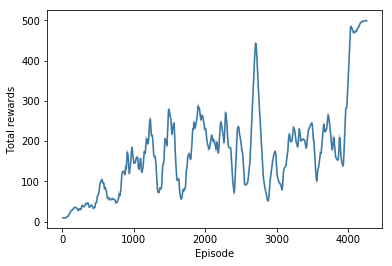

In [64]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

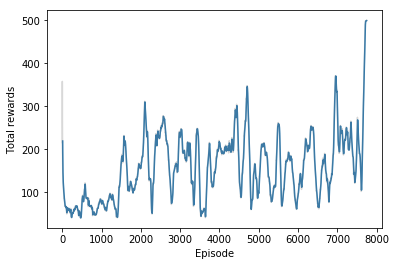

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

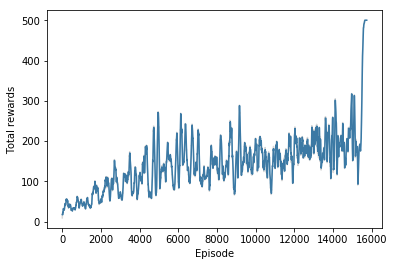

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

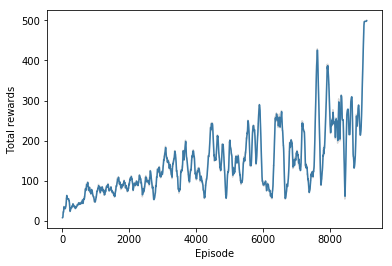

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

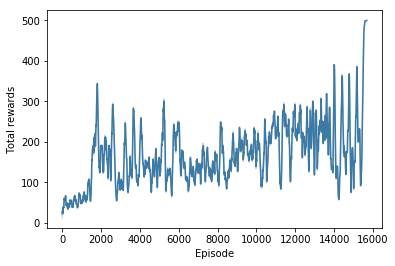

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

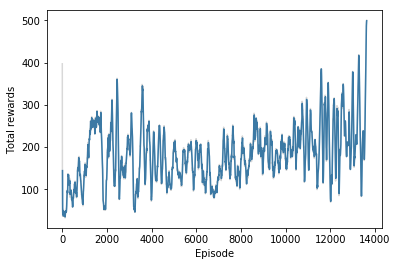

In [32]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

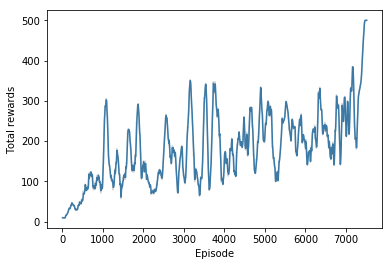

Text(0,0.5,'G losses')

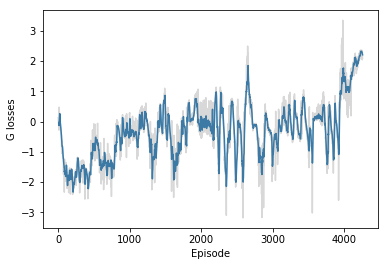

In [65]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

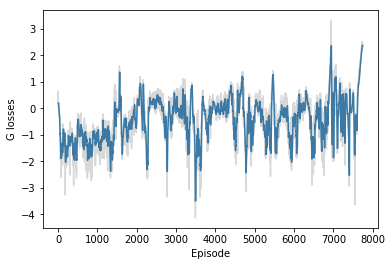

In [45]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

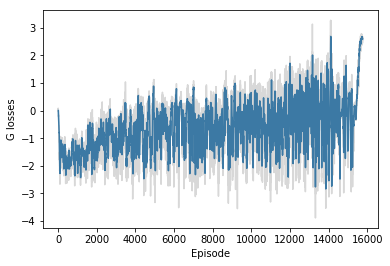

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

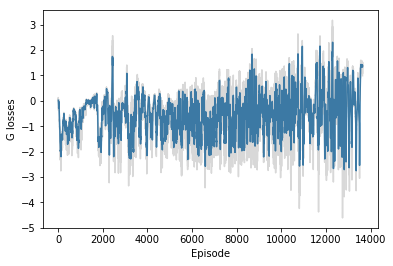

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

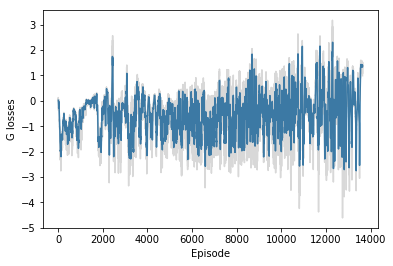

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

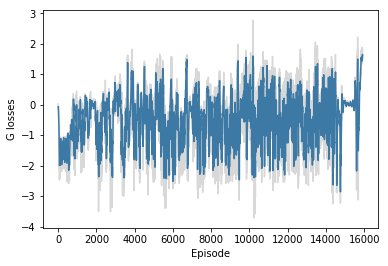
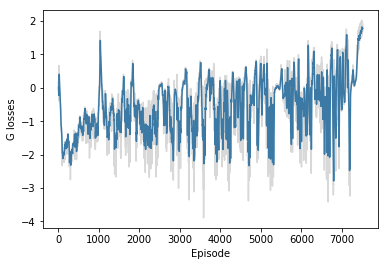

Text(0,0.5,'D losses')

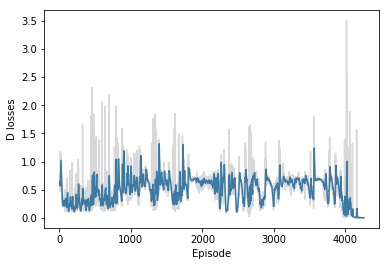

In [66]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

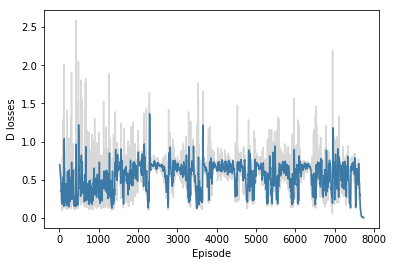

In [46]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

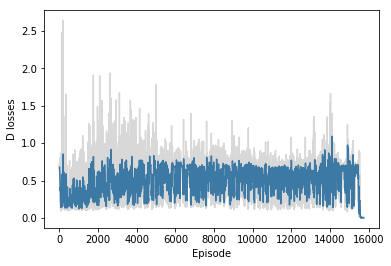

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

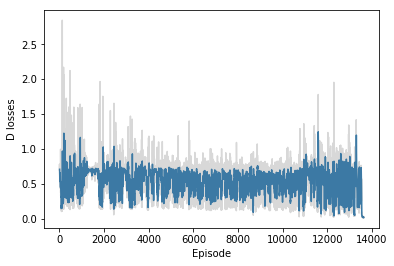

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

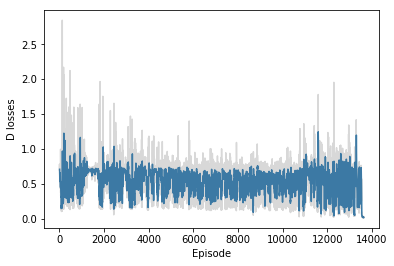

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

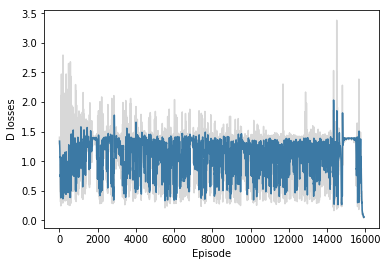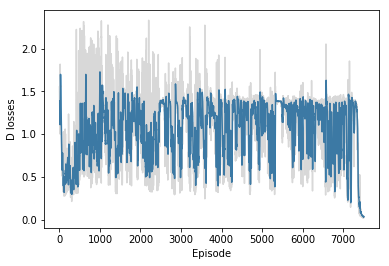

Text(0,0.5,'D losses R')

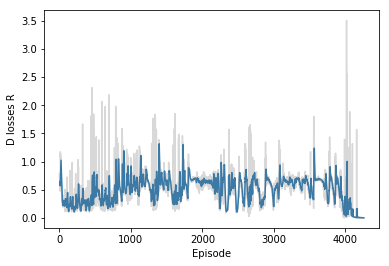

In [67]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

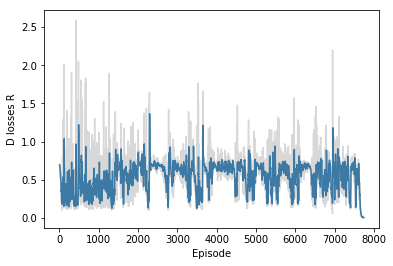

In [47]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

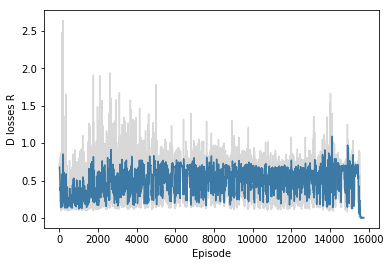

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

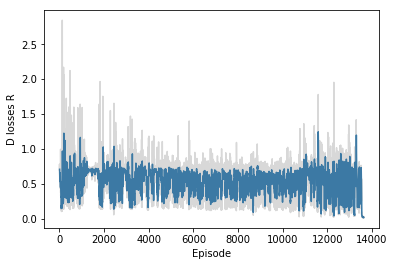

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

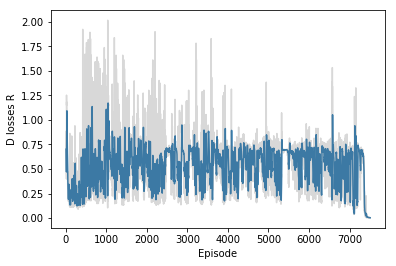

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

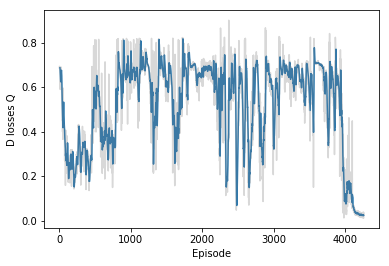

In [68]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

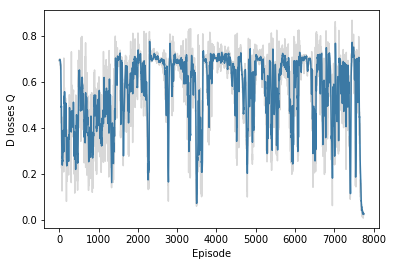

In [48]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

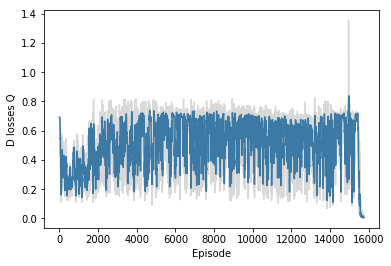

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

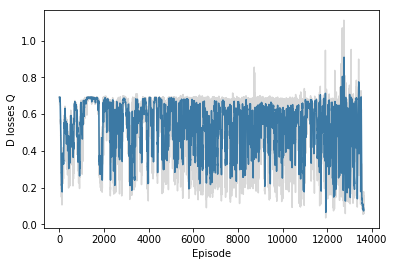

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

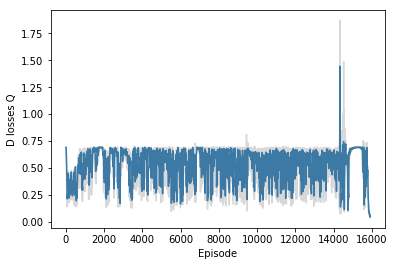

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

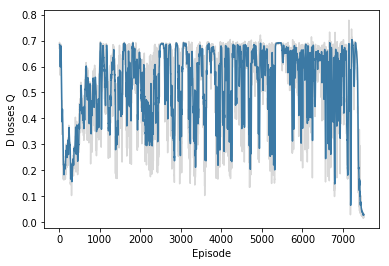

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.